## Import Necessary Libraries

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

## Load the Dataset

In [169]:
df = pd.read_csv('Data\AIDA_Results_IA_Institut.csv')
df.head()

,Start,Diver,Gender,Discipline,Line,Official Top,AP,RP,Card,Points,Remarks,Title Event,Event Type,Day,Category Event
0,1,Tasos Grillakis (GRC),M,FIM,NaN,00:00,33,23 m,YELLOW,12.0,-,Depth Event 2016,Depth Competition,2016-07-17,other
1,2,Antonis Papantonatos (GRC),M,FIM,NaN,00:00,55,47 m,YELLOW,38.0,-,Depth Event 2016,Depth Competition,2016-07-17,other
2,3,Dimitris Koumoulos (GRC),M,CNF,NaN,00:00,55,55 m,WHITE,55.0,-,Depth Event 2016,Depth Competition,2016-07-17,other
3,4,Christos Papadopoulos (GRC),M,CWT,NaN,00:00,55,55 m,WHITE,55.0,OK,Depth Event 2016,Depth Competition,2016-07-17,other
4,5,Anna Chalari (GRC),F,CWT,NaN,00:00,15,15 m,WHITE,15.0,OK,Depth Event 2016,Depth Competition,2016-07-17,other


## Data Preprocessing & Feature Engineering

In [170]:
# Romove duplicates
df = df.drop_duplicates()

In [171]:
# Supposons que df est votre DataFrame et 'Diver' est la colonne à diviser
df[['Name', 'Country']] = df['Diver'].str.rsplit(' ', n=1, expand=True).astype(str)

# Extraire et supprimer les parenthèses des valeurs de la colonne 'Country'
df['Country'] = df['Country'].str.strip('()')


In [172]:
df['RP'] = df['RP'].apply(lambda x: x.split(' ')[0] if x != '-' else None).astype(float)

In [173]:
df['Points'] = df['Points'].replace('-', None).astype(float)

In [174]:
df['Remarks'] = df['Remarks'].str.upper()

In [175]:
# Dropping irrelevant columns
df.drop(['Start', 'Line', 'Official Top'], axis=1, inplace=True)

In [176]:

df['Depth_Difference'] = df['AP'] - df['RP']



In [177]:
# Create the 'Month' column by extracting the month name
df['Day'] = pd.to_datetime(df['Day'])
df['Month'] = df['Day'].dt.month_name().astype(str)

In [178]:
# Convert to datetime if not already
df['Day'] = pd.to_datetime(df['Day'])

# Format dates as 'Day Month Year'
df['Day'] = df['Day'].dt.strftime('%d %B %Y').astype(str)

In [179]:
# Convert gender to a binary numeric variable
df['Gender'] = df['Gender'].map({'H': 0, 'F': 1}).dropna()

# Convert disciplines to numeric values, dropping rows with disciplines not in the list
disciplines = {'CNF': 0, 'FIM': 1, 'CWT': 2, 'CWT-B': 3}
df = df[df['Discipline'].isin(disciplines)].replace(disciplines)

In [180]:
df.head()

,Diver,Gender,Discipline,AP,RP,Card,Points,Remarks,Title Event,Event Type,Day,Category Event,Name,Country,Depth_Difference,Month
0,Tasos Grillakis (GRC),NaN,1,33,23.0,YELLOW,12.0,-,Depth Event 2016,Depth Competition,17 July 2016,other,Tasos Grillakis,GRC,10.0,July
1,Antonis Papantonatos (GRC),NaN,1,55,47.0,YELLOW,38.0,-,Depth Event 2016,Depth Competition,17 July 2016,other,Antonis Papantonatos,GRC,8.0,July
2,Dimitris Koumoulos (GRC),NaN,0,55,55.0,WHITE,55.0,-,Depth Event 2016,Depth Competition,17 July 2016,other,Dimitris Koumoulos,GRC,0.0,July
3,Christos Papadopoulos (GRC),NaN,2,55,55.0,WHITE,55.0,OK,Depth Event 2016,Depth Competition,17 July 2016,other,Christos Papadopoulos,GRC,0.0,July
4,Anna Chalari (GRC),1.0,2,15,15.0,WHITE,15.0,OK,Depth Event 2016,Depth Competition,17 July 2016,other,Anna Chalari,GRC,0.0,July


In [181]:
# Create 'experience dive' feature
df.sort_values(by=['Diver', 'Day'], inplace=True)
df['experience_dive'] = df.groupby('Diver').cumcount()

# Create 'experience discipline' feature
df['experience_discipline'] = df.groupby(['Diver', 'Discipline']).cumcount()


## Exploratory Data Analysis (EDA)

In [182]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23613 entries, 13306 to 26685
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Diver                  23613 non-null  object 
 1   Gender                 8128 non-null   float64
 2   Discipline             23613 non-null  int64  
 3   AP                     23613 non-null  int64  
 4   RP                     23517 non-null  float64
 5   Card                   23613 non-null  object 
 6   Points                 23517 non-null  float64
 7   Remarks                23608 non-null  object 
 8   Title Event            23613 non-null  object 
 9   Event Type             23613 non-null  object 
 10  Day                    23613 non-null  object 
 11  Category Event         23613 non-null  object 
 12  Name                   23613 non-null  object 
 13  Country                23613 non-null  object 
 14  Depth_Difference       23517 non-null  float64
 15  Mon

In [183]:
df.describe()

,Gender,Discipline,AP,RP,Points,Depth_Difference,experience_dive,experience_discipline
count,8128.0,23613.000000,23613.000000,23517.000000,23517.000000,23517.000000,23613.000000,23613.000000
mean,1.0,1.250371,53.197942,50.204575,43.818021,2.949271,9.836573,4.366324
std,0.0,0.771600,24.002183,23.924350,26.911677,14.302574,15.136432,7.580891
min,1.0,0.000000,-1.000000,-2.000000,-99.000000,-107.000000,0.000000,0.000000
25%,1.0,1.000000,38.000000,35.000000,28.000000,0.000000,1.000000,0.000000
50%,1.0,1.000000,51.000000,50.000000,44.000000,0.000000,4.000000,2.000000
75%,1.0,2.000000,69.000000,65.000000,61.000000,0.000000,12.000000,5.000000
max,1.0,2.000000,130.000000,138.000000,130.000000,130.000000,138.000000,95.000000


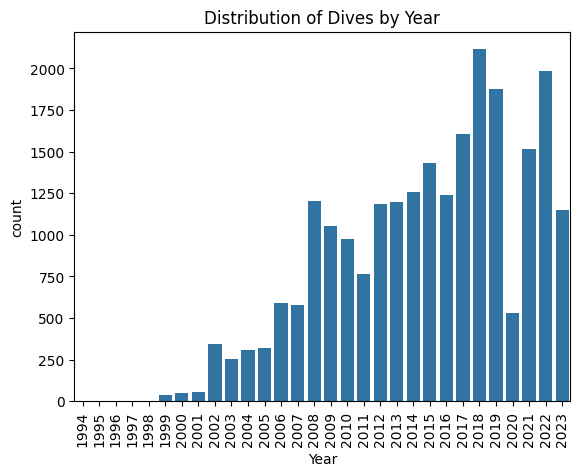

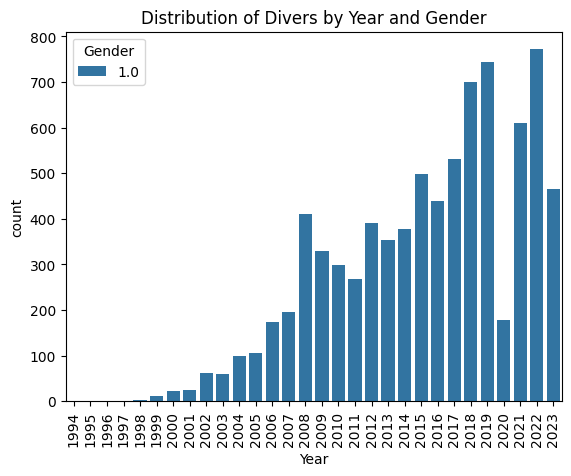

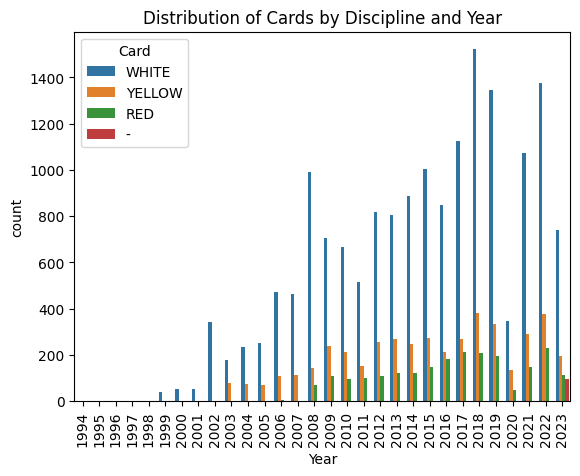

In [184]:
# Distribution of dives by year
df['Day'] = pd.to_datetime(df['Day'])
df['Year'] = df['Day'].dt.year
sns.countplot(x='Year', data=df)
plt.title('Distribution of Dives by Year')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.show()

# Distribution of divers by year and gender
sns.countplot(x='Year', hue='Gender', data=df)
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.title('Distribution of Divers by Year and Gender')
plt.show()

# Distribution of cards by discipline and year
sns.countplot(x='Year', hue='Card', data=df)
plt.title('Distribution of Cards by Discipline and Year')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.show()


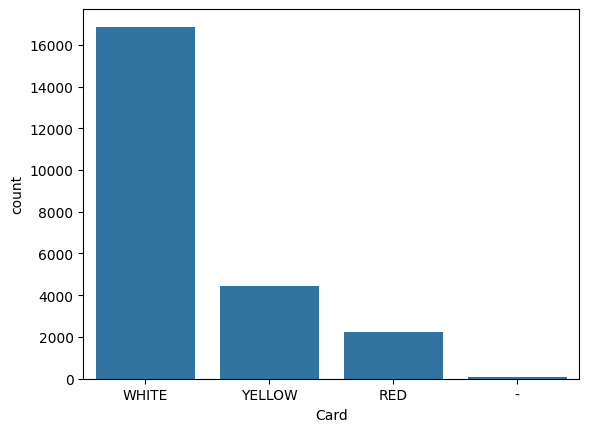

In [185]:
# Plotting distribution of a variable
sns.countplot(x='Card', data=df)
plt.show()

## Preparing Data for Machine Learning

In [186]:
# For numerical columns
df['AP'] = df['AP'].fillna(df['AP'].mean())
df['RP'] = df['RP'].fillna(df['RP'].mean())

# For categorical columns, you can replace with mode or a specific category
df['Discipline'] = df['Discipline'].fillna(df['Discipline'].mode()[0])



## Building a Machine Learning Model

In [189]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecting features for clustering
features = df[['Discipline', 'AP', 'experience_dive', 'experience_discipline']]
features = StandardScaler().fit_transform(features)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(features)

# Analyze the clusters
df.groupby('cluster').mean()

# Visualize the clusters
sns.scatterplot(x='AP', y='experience_dive', hue='cluster', data=df)
plt.title('Cluster Visualization')
plt.show()


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


TypeError: agg function failed [how->mean,dtype->object]